In [1]:
import keras
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tqdm
import os
import skimage.io
from PIL import Image
import pickle

Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.4'

In [2]:
#variables
img_data=[]
label_data = []
resize_dim = (64,64)
target = ['ups','dhl','fedex','aldi','cocacola','mcdonalds']

num_to_label = ['HP', 'adidas', 'adidas_text', 'aldi', 'apple', 'becks_symbol', 'becks_text', 'bmw', 'carlsberg_symbol', 'carlsberg_text', 'chimay_symbol', 'chimay_text', 'cocacola', 'corona_symbol', 'corona_text', 'dhl', 'erdinger_symbol', 'erdinger_text', 'esso_symbol', 'esso_text', 'fedex', 'ferrari', 'ford', 'fosters_symbol', 'fosters_text', 'google', 'guinness_symbol', 'guinness_text', 'heineken', 'milka', 'nvidia_symbol', 'nvidia_text', 'paulaner_symbol', 'paulaner_text', 'pepsi_symbol', 'pepsi_text', 'rittersport', 'shell', 'singha_symbol', 'singha_text', 'starbucks', 'stellaartois_symbol', 'stellaartois_text', 'texaco', 'tsingtao_symbol', 'tsingtao_text', 'ups']

In [4]:
#loading Flickr27 Dataset
image_path = '/home/jagadeesh/datasets/FlickrLogos_27/flickr_logos_27_dataset_images/'
annotations = open('/home/jagadeesh/datasets/FlickrLogos_27/flickr_logos_27_dataset_training_set_annotation.txt')

with open('/home/jagadeesh/datasets/FlickrLogos_27/flickr_logos_27_dataset_training_set_annotation.txt') as foo:
    lines = len(foo.readlines())
    
for line in tqdm.tqdm(annotations,total=lines):
    line = line.split()
    x = int(line[3])
    y = int(line[4])
    w = int(line[5])
    h = int(line[6])
    try:
        if line[1].lower() in target:
            img = Image.open(image_path + line[0]).crop((x,y,w,h)).resize(resize_dim)
            img = np.array(img)
            img_data.append(img)
            label_data.append(line[1].lower())
    except:
        pass

100%|██████████| 4536/4536 [00:03<00:00, 1472.47it/s]


In [5]:
file_list = '/home/jagadeesh/datasets/flogo32/all.spaces.txt'
image_path = '/home/jagadeesh/datasets/flogo32/classes/jpg/'
bb_path = '/home/jagadeesh/datasets/flogo32/classes/masks/'



with open(file_list) as foo:
    lines = len(foo.readlines())
nlc = 0
for line in tqdm.tqdm(open(file_list),total=lines):
    line = line.split()
    if line[0] == 'no-logo':
        continue
    else:
        c=0
        try:
            label = open(bb_path + line[0] + '/' + line[1] + '.bboxes.txt')
        except FileNotFoundError:
            continue
        for l in label:
            c=c+1
            if c > 1:
                if line[0].lower() in target:
                    x,y,w,h = l.split()
                    x = int(x)
                    y = int(y)
                    w = int(w) + x
                    h = int(h) + y
                    img = Image.open(image_path + line[0] + '/' + line[1]).crop((x,y,w,h)).resize(resize_dim)
                    img = np.array(img)
                    img_data.append(img)
                    label_data.append(line[0].lower())


100%|██████████| 8240/8240 [00:09<00:00, 876.05it/s]


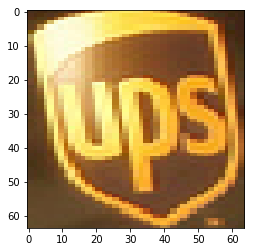

In [6]:
plt.imshow(img_data[-1])

In [7]:
PTF = "/home/jagadeesh/datasets/FlickrLogos_47/logo_data/"

for image in tqdm.tqdm(os.listdir(PTF)):
    if image.endswith('.png') and image.find('mask') is -1:
        image_bbd = image.replace('png', 'gt_data.txt')
        f = open(PTF + image_bbd)
        for line in f:
            line = line.strip().split()
            # coordinates
            if num_to_label[int(line[4])] in target:
                x = int(line[0])
                y = int(line[1])
                w = int(line[2])
                h = int(line[3])
                img = Image.fromarray(skimage.io.imread(PTF + image)).crop((x, y, w, h)).resize(resize_dim)
                img = np.array(img)
                img = img_data.append(img)
                label = num_to_label[int(line[4])]
                label_data.append(label.lower())

100%|██████████| 10457/10457 [00:30<00:00, 344.83it/s]


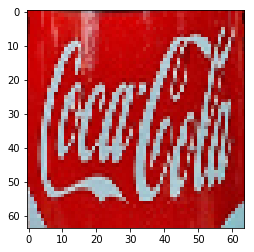

In [8]:
plt.imshow(img_data[-7])

In [9]:
len(img_data)

1795

In [10]:

from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
label_encoded = label_encode.fit_transform(label_data)

In [11]:
print(len(set(label_encoded)))

6


In [12]:
img_data = np.array(img_data)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(img_data,label_encoded,test_size=0.10,shuffle=True)

In [14]:

final_layer_output = len(set(label_encoded))
input_shape = X_train[0].shape

In [15]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout


def create_model():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(12, 12), activation='relu',input_shape=input_shape,bias_initializer="zeros"))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(32, kernel_size=(8, 8), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(16, kernel_size=(2, 2), activation='relu',input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(final_layer_output,activation='softmax'))
    return model


model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 53, 53, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 32)        262176    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2064      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
__________

In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=60,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.4,
                            zoom_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [18]:
X_train.shape

(1615, 64, 64, 3)

In [19]:

batch_size = 10
epochs = 20

history = model.fit_generator(datagen.flow(X_train,y_train),validation_data=valid_datagen.flow(X_val,y_val),epochs=epochs,steps_per_epoch=100,validation_steps=100,use_multiprocessing=True)


Epoch 1/20
100/100 [==============================] - 57s 572ms/step - loss: 1.2918 - acc: 0.5181 - val_loss: 0.8913 - val_acc: 0.7214
Epoch 2/20
100/100 [==============================] - 52s 522ms/step - loss: 0.8609 - acc: 0.7126 - val_loss: 0.5367 - val_acc: 0.8338
Epoch 3/20
100/100 [==============================] - 49s 488ms/step - loss: 0.6151 - acc: 0.7935 - val_loss: 0.4964 - val_acc: 0.8501
Epoch 4/20
100/100 [==============================] - 49s 487ms/step - loss: 0.5356 - acc: 0.8196 - val_loss: 0.4314 - val_acc: 0.8823
Epoch 5/20
100/100 [==============================] - 49s 488ms/step - loss: 0.4549 - acc: 0.8565 - val_loss: 0.3032 - val_acc: 0.9222
Epoch 6/20
100/100 [==============================] - 49s 487ms/step - loss: 0.4450 - acc: 0.8546 - val_loss: 0.3474 - val_acc: 0.8945
Epoch 7/20
100/100 [==============================] - 49s 487ms/step - loss: 0.4028 - acc: 0.8666 - val_loss: 0.5573 - val_acc: 0.8225
Epoch 8/20
100/100 [==============================] - 4

In [20]:
test_set = X_val[:10] / 255
test_res = model.predict_proba(test_set)
for pred,truth in zip(test_res,y_val):
    print(label_encode.inverse_transform([truth]),'===>',label_encode.inverse_transform([np.argmax(pred,axis=0)]),pred.max(),np.argmax(pred,axis=0))

['ups'] ===> ['ups'] 0.8819111 5
['mcdonalds'] ===> ['mcdonalds'] 0.8117483 4
['cocacola'] ===> ['cocacola'] 0.9996402 1
['cocacola'] ===> ['cocacola'] 0.9940369 1
['cocacola'] ===> ['cocacola'] 0.99983144 1
['fedex'] ===> ['fedex'] 0.9965456 3
['cocacola'] ===> ['cocacola'] 0.97655666 1
['mcdonalds'] ===> ['cocacola'] 0.3199784 1
['aldi'] ===> ['aldi'] 1.0 0
['fedex'] ===> ['fedex'] 0.99143195 3


In [3]:
from keras.models import load_model
import pickle

def load_k_model(model_dir):
    return load_model(model_dir)

def load_labelenc(pickle_dir):
    labenc = open(pickle_dir,'rb')
    labenc = pickle.load(labenc)
    return labenc

label_encode = load_labelenc("/home/jagadeesh/Documents/repo/LogoNet/labels/logonet02.pickle")
model = load_k_model("/home/jagadeesh/Documents/repo/LogoNet/models/logonet02.h5")

Using TensorFlow backend.


/home/jagadeesh/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v


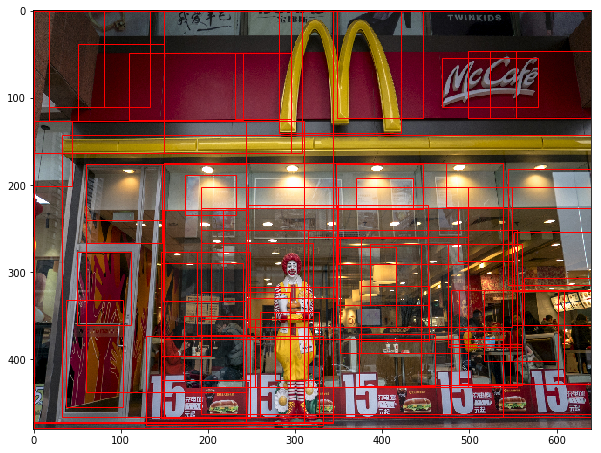

In [8]:
import skimage.io
import selectivesearch
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

ss_arr = []

img = Image.open('/home/jagadeesh/Pictures/mcdg3.jpg').resize((640,480))
img = np.array(img)

img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0, min_size=500)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))

candidates = []

for r in regions:
    # excluding same rectangle (with different segments)
    if r['rect'] in candidates:
        continue
    # excluding regions smaller than 2000 pixels
    if r['size'] < 2000:
        continue
    # distorted rects
    x, y, w, h = r['rect']
    if h is 0 or w is 0:
        continue
    if w / h > 2 or h / w > 2:
        continue
    candidates.append(r['rect'])
        
    rect = mpatches.Rectangle((x,y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
    image = Image.fromarray(img).crop((x,y,x+w,h+y)).resize(resize_dim)
    ss_arr.append(np.array(image))

ax.imshow(img)
ss_arr = np.array(ss_arr) / 255

cocacola ===> 0.9982626


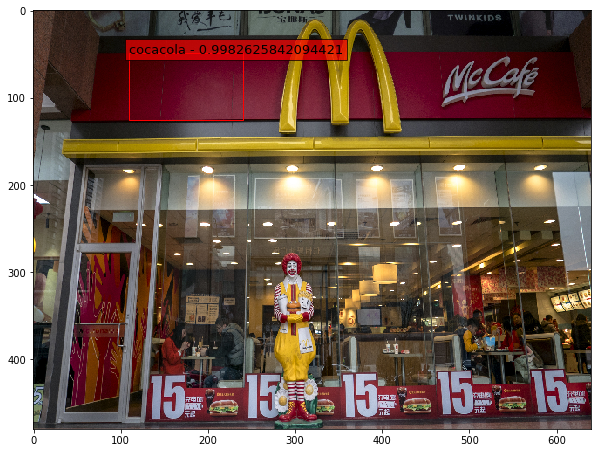

In [9]:
preds = []
probs = []


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
pred = model.predict_proba(ss_arr)


for j,i in zip(pred,range(len(pred))):
    preds.append(label_encode.inverse_transform([np.argmax(j,axis=0)])[0])
    probs.append(j.max())



x,y,w,h = candidates[probs.index(max(probs))]
rect = mpatches.Rectangle((x,y), w, h, fill=False, edgecolor='red', linewidth=1)  
ax.add_patch(rect)
ax.text(x,y,"{} - {}".format(preds[probs.index(max(probs))], max(probs)),fontsize=13,bbox=dict(facecolor='red', alpha=0.7))

ax.imshow(img)
print(preds[probs.index(max(probs))],'===>',max(probs))

In [73]:
max(t_prob)

0.7839587

In [23]:
model.save("models/logonet02.h5")
with open('labels/logonet02.pickle', 'wb') as handle:
    pickle.dump(label_encode, handle, protocol=pickle.HIGHEST_PROTOCOL)